## THIS IS NEW: 5-fold cross validation on R2 score using random forest regressor

## TAKING A LOT OF COMPUTATION TIME

In [1]:
import os
import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import warnings

import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")
np.random.seed(23)

In [2]:
# Locate the directory in Google Drive
DIRECTORY = 'hopkins_export/'  # Adjust this path to your specific folder in Google Drive
#arr = os.listdir(DIRECTORY)

In [3]:
# the list of columns to be dropped
drop_ls = [
    "expected_time",
    "flip_time",
    "stim_pos",
    "user_pos",
    "lambda_val",
    "change_rate_x",
]


In [4]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

def average_array(cell):
    return np.mean(cell)

arr = [f for f in os.listdir(DIRECTORY) if f.endswith('.csv')]
arr = arr[:5]

scores1 = []
scores2 = []
sample_indices = []

# Two trials
for trial in range(2):
    scores = []
    # Enumerate across all samples
    for i, subject_ in enumerate(arr):
        subject = pd.read_csv('hopkins_export/' + subject_)
        #y_pos = subject["stim_pos"].to_numpy()  # stimulus position
        # Prepare X variables and y labels
        X = subject.drop(columns=drop_ls).to_numpy()
        y_pos_dif = subject["user_pos"].to_numpy() - subject["stim_pos"].to_numpy()

        # SWITCH TO THESE OTHER TWO IF INTERESTED
        # REMEMBER TO CHANGE NAMES
        #y_pos = subject["stim_pos"].to_numpy()  # position
        #y_speed = subject["change_rate_x"].to_numpy()  # speed of change

        samples = np.geomspace(1000, len(y_pos_dif), num=3, dtype=int)
        kf = KFold(shuffle=True, random_state=23)
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-2, random_state=23)

        score_k_fold_samples = []

        # 5-fold cross validation
        for sample in samples:
            np.random.seed(23)
            sample_index = np.random.choice(len(y_pos_dif), sample, replace=False)
            X_sample = X[sample_index]
            y_sample = y_pos_dif[sample_index]

            score_k_fold = []
            for j, (train_index, test_index) in enumerate(kf.split(X_sample)):
                rf.fit(X_sample[train_index], y_sample[train_index])
                score_k_fold.append(
                    r2_score(rf.predict(X_sample[test_index]), y_sample[test_index])
                )
            score_k_fold_samples.append(score_k_fold)

        scores.append(score_k_fold_samples)
    if trial ==0:
        scores1 = scores
        with open("original_regression_speed_scores.pkl", "wb") as f:
            pickle.dump(scores, f)
        scores1_df = pd.DataFrame(scores1)
        scores1_df.to_csv("y_pos_dif_r2_scores_23_trial_1_5subjects.csv", index=False)
        averaged_df1 = scores1_df.applymap(average_array)
        averaged_df1.to_csv("y_pos_dif_r2_scores_23_trial_1_5subjects_mean.csv", index=False)
    else:
       scores2 = scores
       with open("original_regression_speed_scores.pkl", "wb") as f:
           pickle.dump(scores, f)
       scores2_df = pd.DataFrame(scores2)
       scores2_df.to_csv("y_pos_dif_r2_scores_23_trial_2_5subjects.csv", index=False)
       averaged_df2 = scores2_df.applymap(average_array)
       averaged_df2.to_csv("y_pos_dif_r2_scores_23_trial_2_5subjects_mean.csv", index=False) 


## Here is how to generate the plot

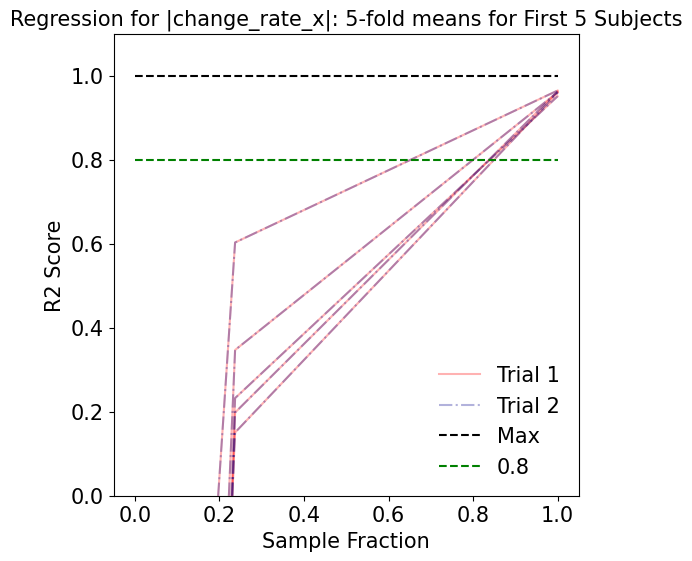

In [5]:
sample_fractions = samples / len(y_pos_dif) # using last sample as reference

fig, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(labelsize=15)

# plot average R2 scores for Trial 1
for score in scores1:
    ax.plot(sample_fractions, np.mean(score, axis=1), color = 'red', alpha=0.3, label='Trial 1' if 'Trial 1' not in ax.get_legend_handles_labels()[1] else "")

# plot average R2 scores for Trial 2
for score in scores2:
    ax.plot(sample_fractions, np.mean(score, axis=1), color='#00008B', alpha=0.3, linestyle = '-.', label='Trial 2' if 'Trial 2' not in ax.get_legend_handles_labels()[1] else "")

# horizontal grid lines
ax.hlines(1, 0, 1, linestyle="--", color="black", label="Max")
ax.hlines(0.8, 0, 1, linestyle="--", color="green", label="0.8")

ax.set_xlabel("Sample Fraction", fontsize=15)
ax.set_ylabel("R2 Score", fontsize=15)
ax.legend(frameon=False, fontsize=15, loc=4)
ax.set_ylim(0,1.1)
plt.title("Regression for |user_pos - stim_pos|: 5-fold means for First 5 Subjects", fontsize=15)
plt.show()